In [1]:
import sys
sys.path.insert(0, '/app') 

import pandas as pd
from preprocessing.data_preprocessing import preprocess_devices, preprocess_devices_features, preprocess_relationships, get_node_features
from feature_engineering.feature_engineering import get_negative_edges, set_positive_edge_labels
from dataset_generation.dataset_generation import generate_node_classification_dataset, generate_edge_prediction_dataset, generate_subgraph_classification_dataset
from scenario_identification.utils.path_helper import DatasetTask, DatasetType, set_constants

import config

import pickle
import cProfile

from scenario_identification.utils.path_helper import get_dataset_file_path, get_profiler_output_path
import networkx as nx
    

df_devices = df_device_features = pd.read_csv(config.DEVICES_PATH)

df_devices  = preprocess_devices(df_devices)
df_device_features = preprocess_devices_features(df_device_features)
df_node_features = get_node_features(df_device_features)


df_node_features.to_csv(config.OUT_NODE_RAW_DF)

df_relaionships = pd.read_csv(config.RELATIONSHIPS_PATH)
df_relaionships = preprocess_relationships(df_relaionships)

df_relaionships.to_csv(config.OUT_RELATION_RAW_DF)

# Preprocess data


In [2]:
relationships_df = df_relaionships
devices_df = df_node_features

In [3]:
def generate_subgraph_classification_dataset(devices_df, relationships_df):
    ts_subgraphs_dict = {}

    for ts, group in relationships_df.groupby('ts'):
        G = nx.Graph()

        # Add nodes
        devices_at_ts = devices_df[devices_df['ts'] == ts]
        for index, row in devices_at_ts.iterrows():
            node_id = row['u']
            node_attrs = row.drop(['ts', 'u']).to_dict()
            G.add_node(node_id, **node_attrs)

        # Add edges
        for index, row in group.iterrows():
            u, v, dist = row['u'], row['i'], row['dist']
            G.add_edge(u, v, dist=dist)

        # Create subgraphs and filter out isolated nodes
        for sg in nx.connected_components(G):
            if len(sg) > 1:  # Remove subgraphs with no relationships (i.e., isolated nodes)
                subgraph = G.subgraph(sg)
                label = 1 if any(data['label'] == 1 for node, data in subgraph.nodes(data=True)) else 0
                subgraph.graph['label'] = label

                if ts not in ts_subgraphs_dict:
                    ts_subgraphs_dict[ts] = []
                ts_subgraphs_dict[ts].append(subgraph)

    return ts_subgraphs_dict

ts_subgraphs_dict = generate_subgraph_classification_dataset(devices_df, relationships_df)

### Check Graph structure

In [4]:

def print_subgraph_details(subgraph):
    print("Nodes:")
    for node, attrs in subgraph.nodes(data=True):
        print(f"  Node {node} with attributes {attrs}")
        
    print("\nEdges:")
    for u, v, attrs in subgraph.edges(data=True):
        print(f"  Edge ({u}, {v}) with attributes {attrs}")

# Example usage:
specific_ts = 100
if specific_ts in ts_subgraphs_dict:
    
    for subgraph in ts_subgraphs_dict[specific_ts]:
        # Take the first subgraph at time 100
        print_subgraph_details(subgraph)
else:
    print(f"No subgraphs found for time {specific_ts}.")

Nodes:
  Node 9.0 with attributes {'label': 0.0, 'latitude': 883.96, 'longitude': 550.77, 'shape_status_DEFORMED': 0.0, 'shape_status_ORIGINAL_MANUFACTURED': 1.0, 'signal': 0.0, 'speed': 0.0, 'status_ACTIVE': 1.0, 'status_ERROR': 0.0, 'status_INACTIVE': 0.0, 'type_EMERGENCY_CENTER': 0.0, 'type_INDUCTION_LOOP': 0.0, 'type_SMART_PHONE': 0.0, 'type_TRAFFIC_CAMERA': 0.0, 'type_TRAFFIC_LIGHT': 0.0, 'type_VEHICLE': 1.0}
  Node 3.0 with attributes {'label': 0.0, 'latitude': 866.63, 'longitude': 577.69, 'shape_status_DEFORMED': 0.0, 'shape_status_ORIGINAL_MANUFACTURED': 1.0, 'signal': 0.0, 'speed': 0.0, 'status_ACTIVE': 1.0, 'status_ERROR': 0.0, 'status_INACTIVE': 0.0, 'type_EMERGENCY_CENTER': 0.0, 'type_INDUCTION_LOOP': 0.0, 'type_SMART_PHONE': 0.0, 'type_TRAFFIC_CAMERA': 1.0, 'type_TRAFFIC_LIGHT': 0.0, 'type_VEHICLE': 0.0}
  Node 13.0 with attributes {'label': 0.0, 'latitude': 887.21, 'longitude': 525.6, 'shape_status_DEFORMED': 0.0, 'shape_status_ORIGINAL_MANUFACTURED': 1.0, 'signal': 2048.

In [5]:
def count_labels_in_subgraphs(ts_subgraphs_dict):
    positive_count = 0
    negative_count = 0

    for ts, subgraphs in ts_subgraphs_dict.items():
        for subgraph in subgraphs:
            label = subgraph.graph.get('label', None)
            if label is None:
                continue  # Skip if label is not set
            if label == 1:
                positive_count += 1
            elif label == 0:
                negative_count += 1
                
    return positive_count, negative_count



positive_count, negative_count = count_labels_in_subgraphs(ts_subgraphs_dict)
print(f"Positive subgraphs: {positive_count}")
print(f"Negative subgraphs: {negative_count}")

Positive subgraphs: 839
Negative subgraphs: 16168


### Check with visualisations

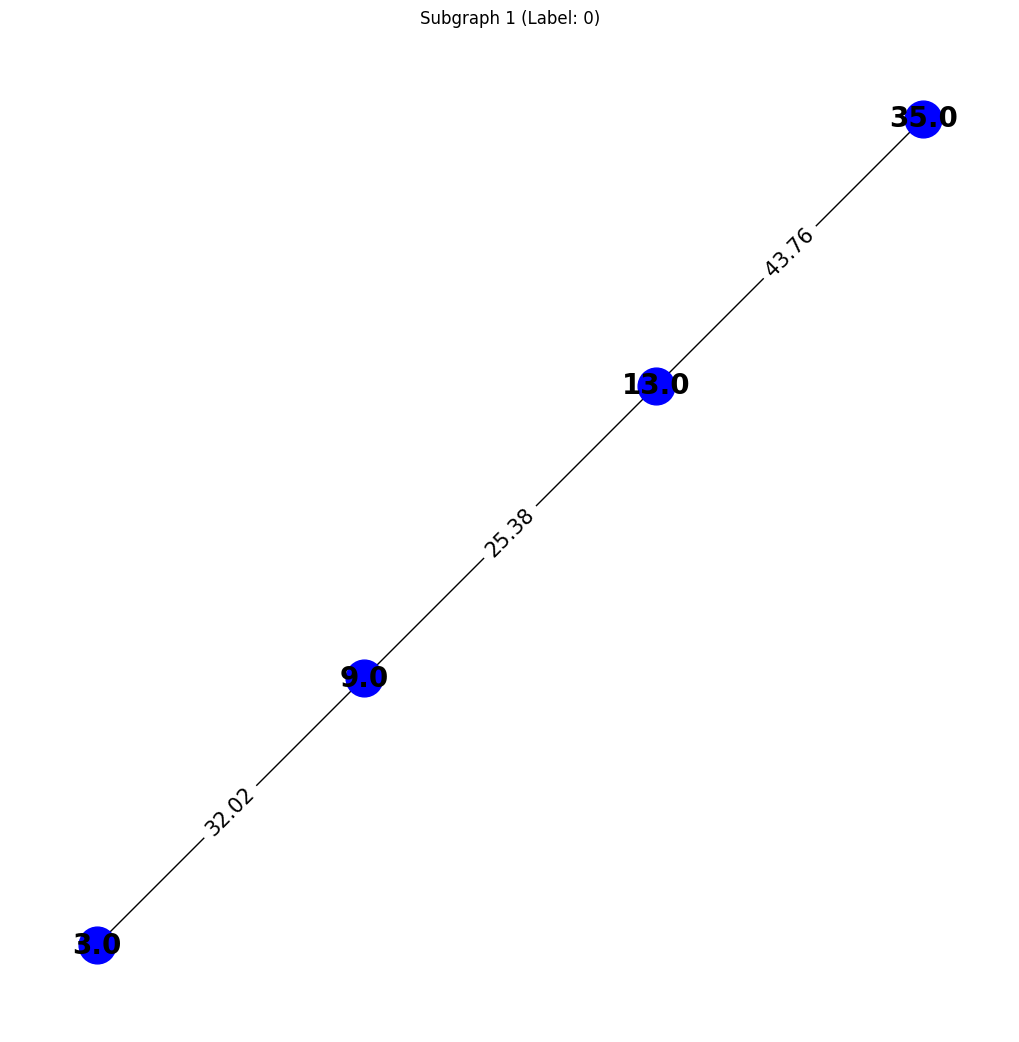

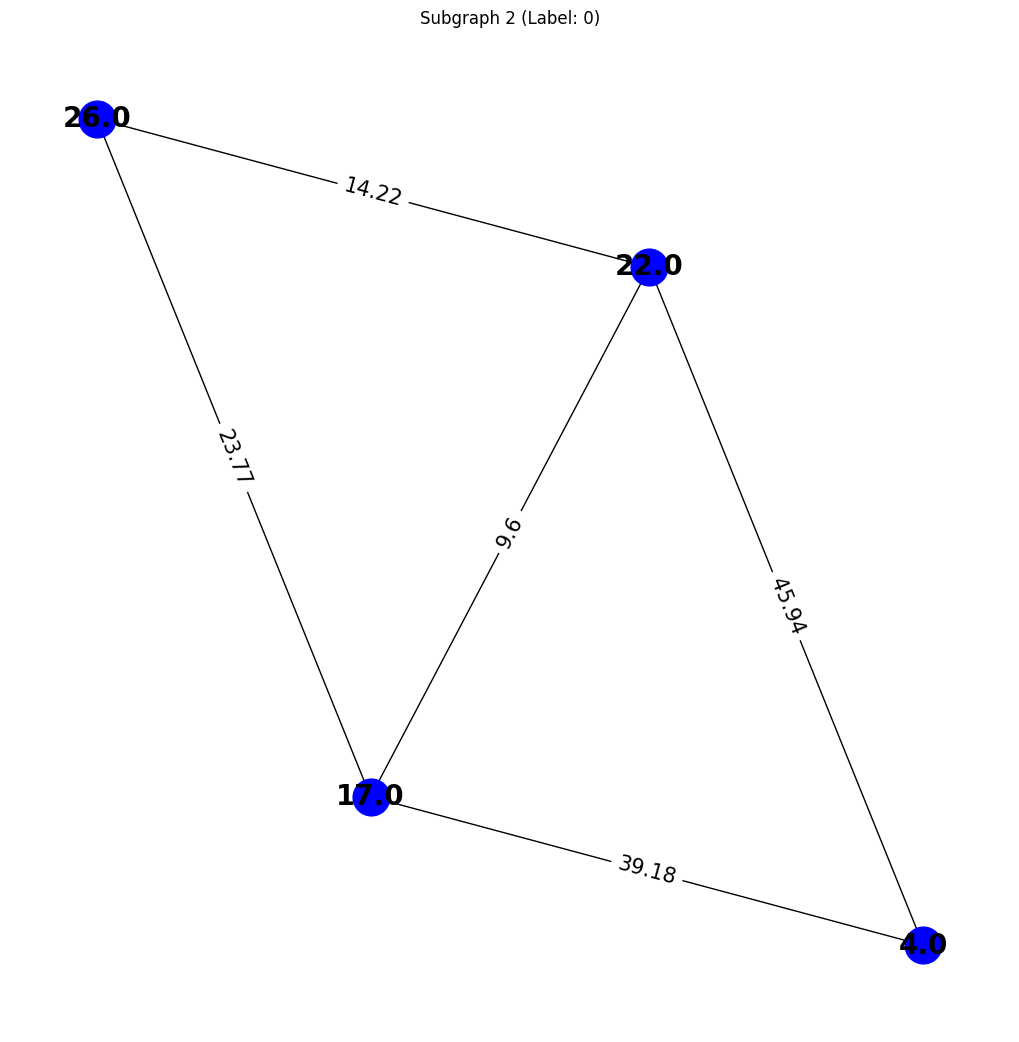

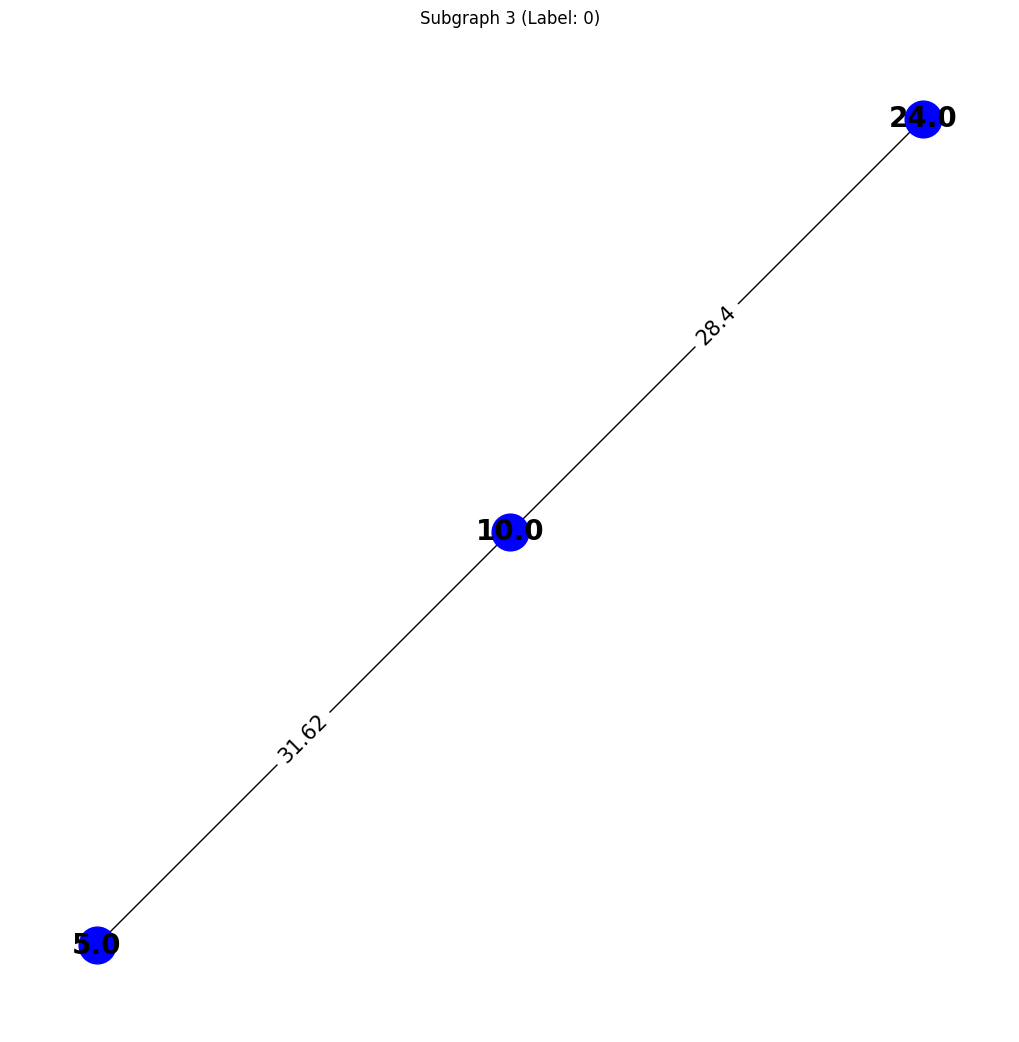

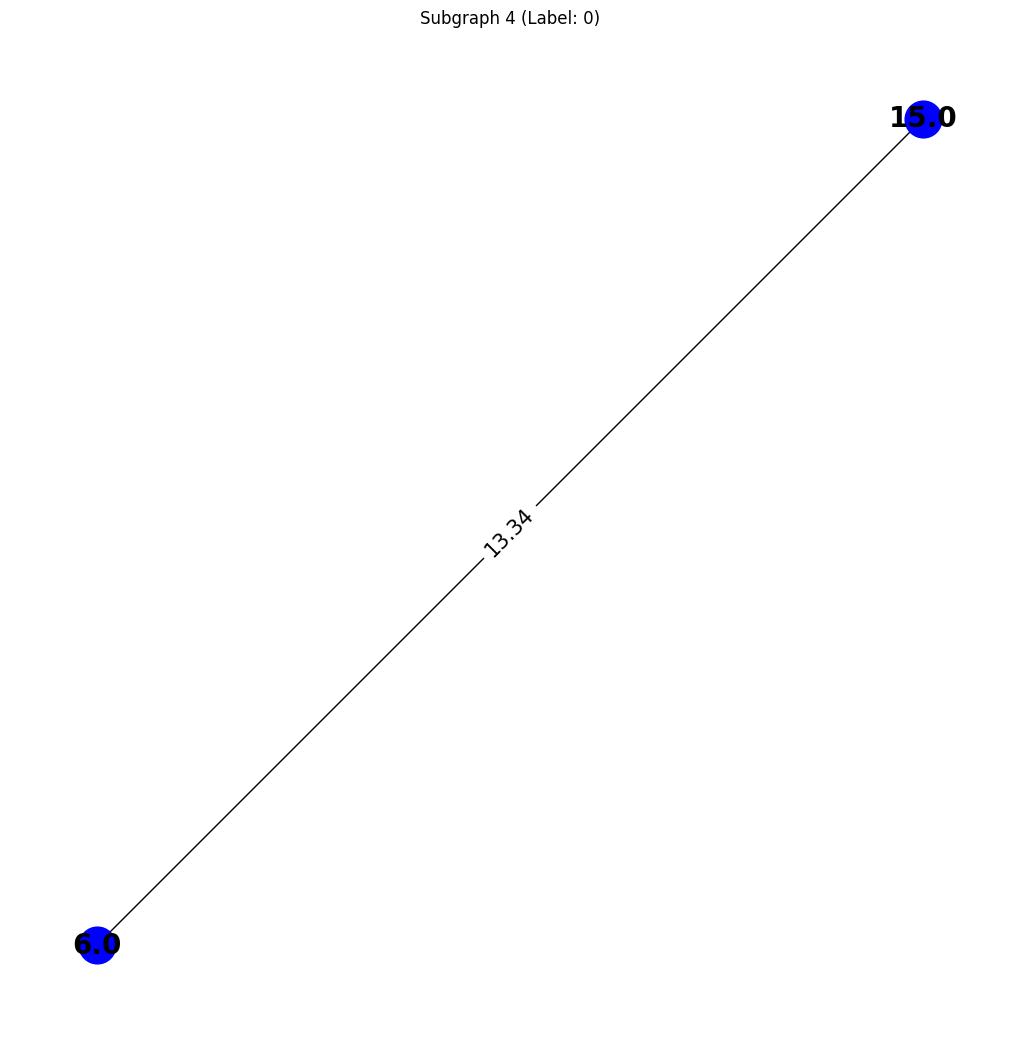

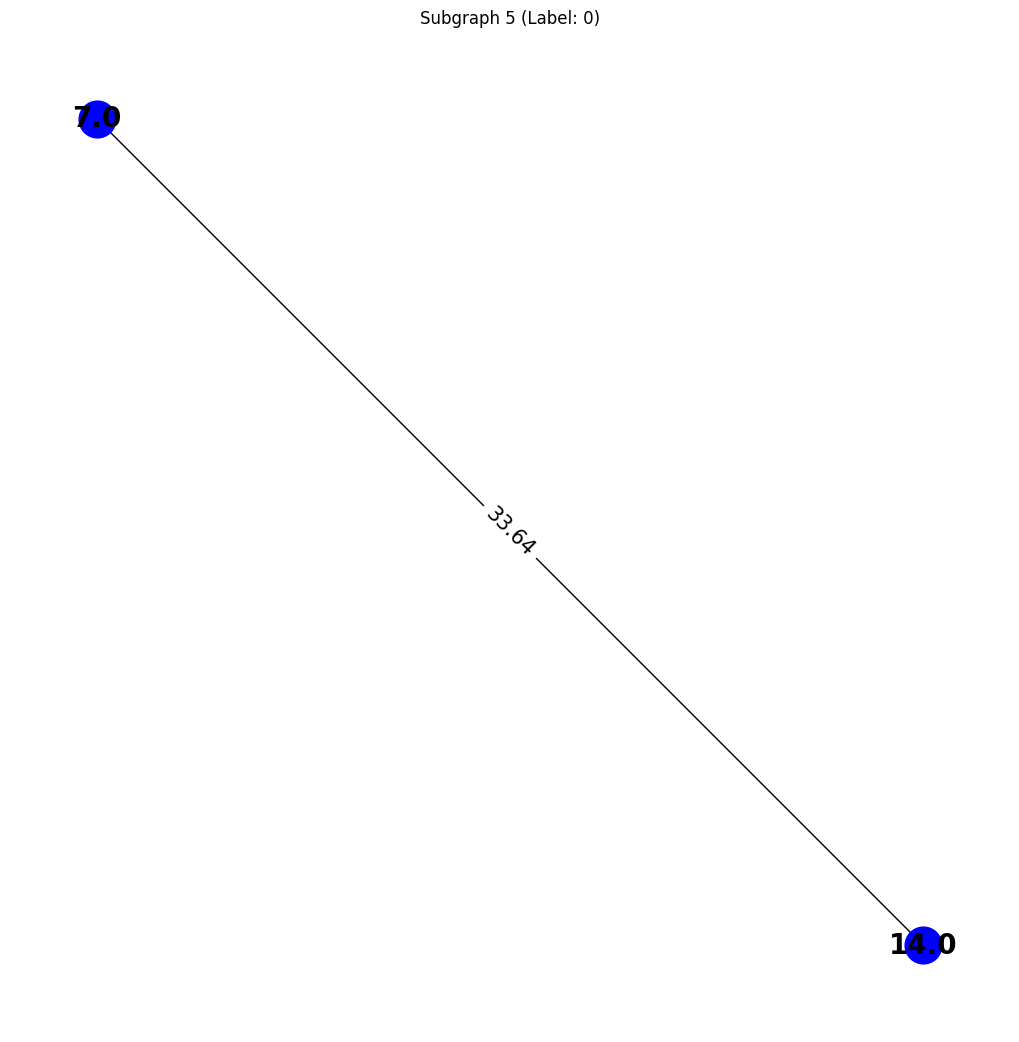

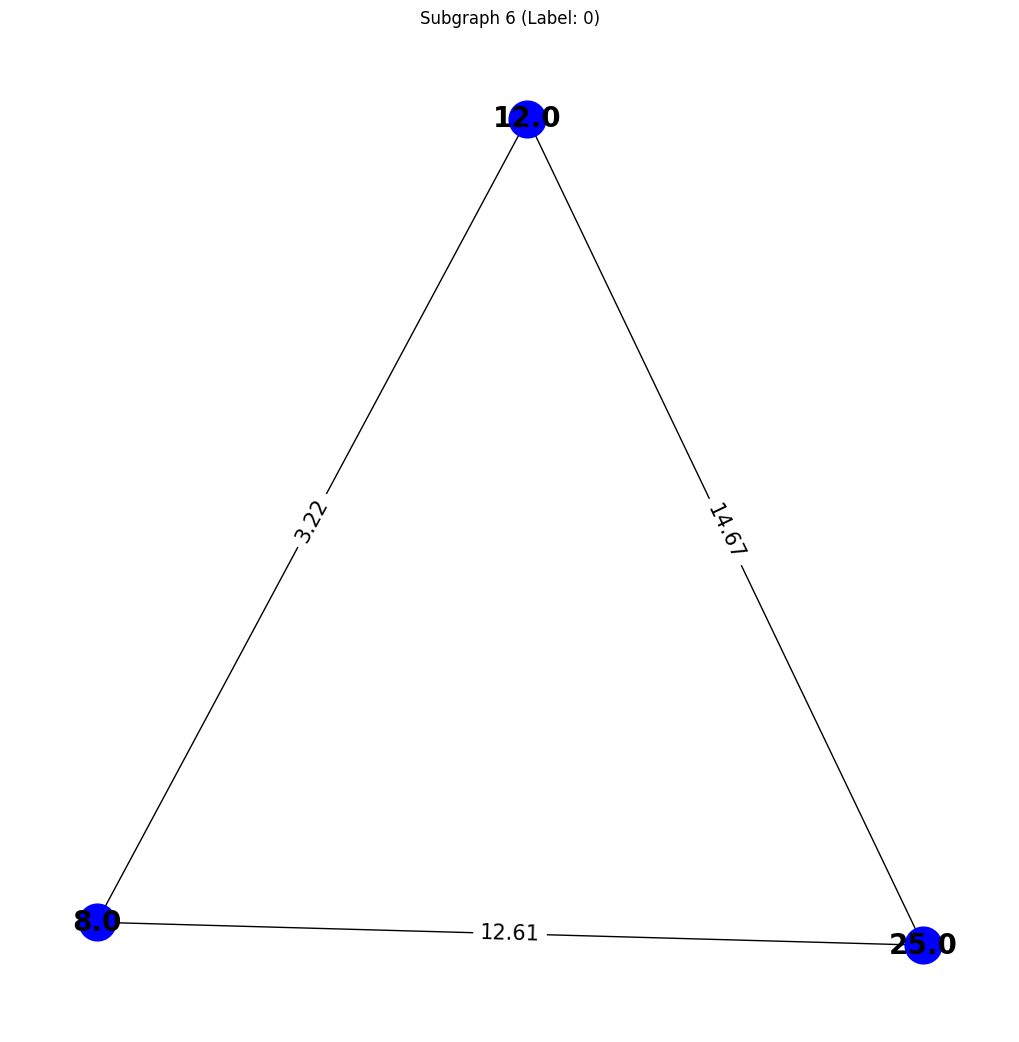

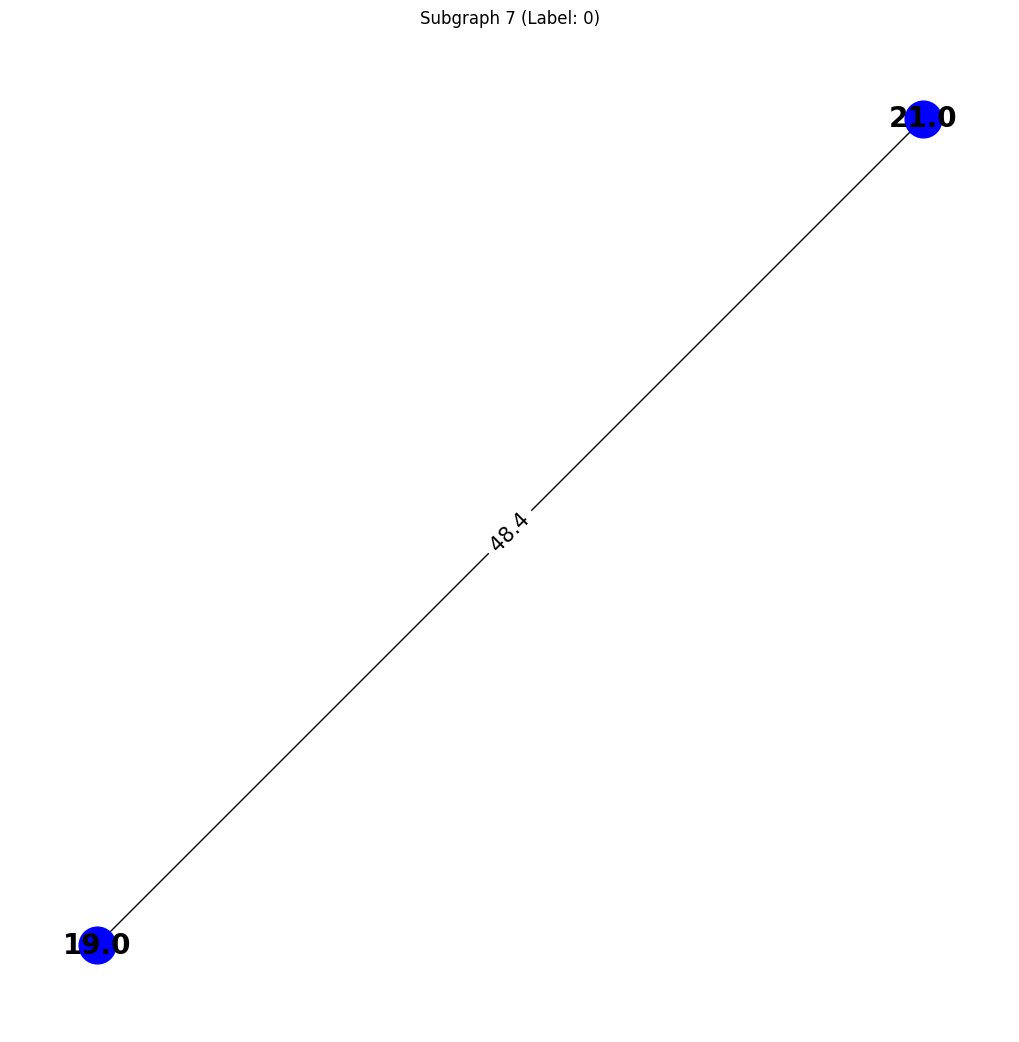

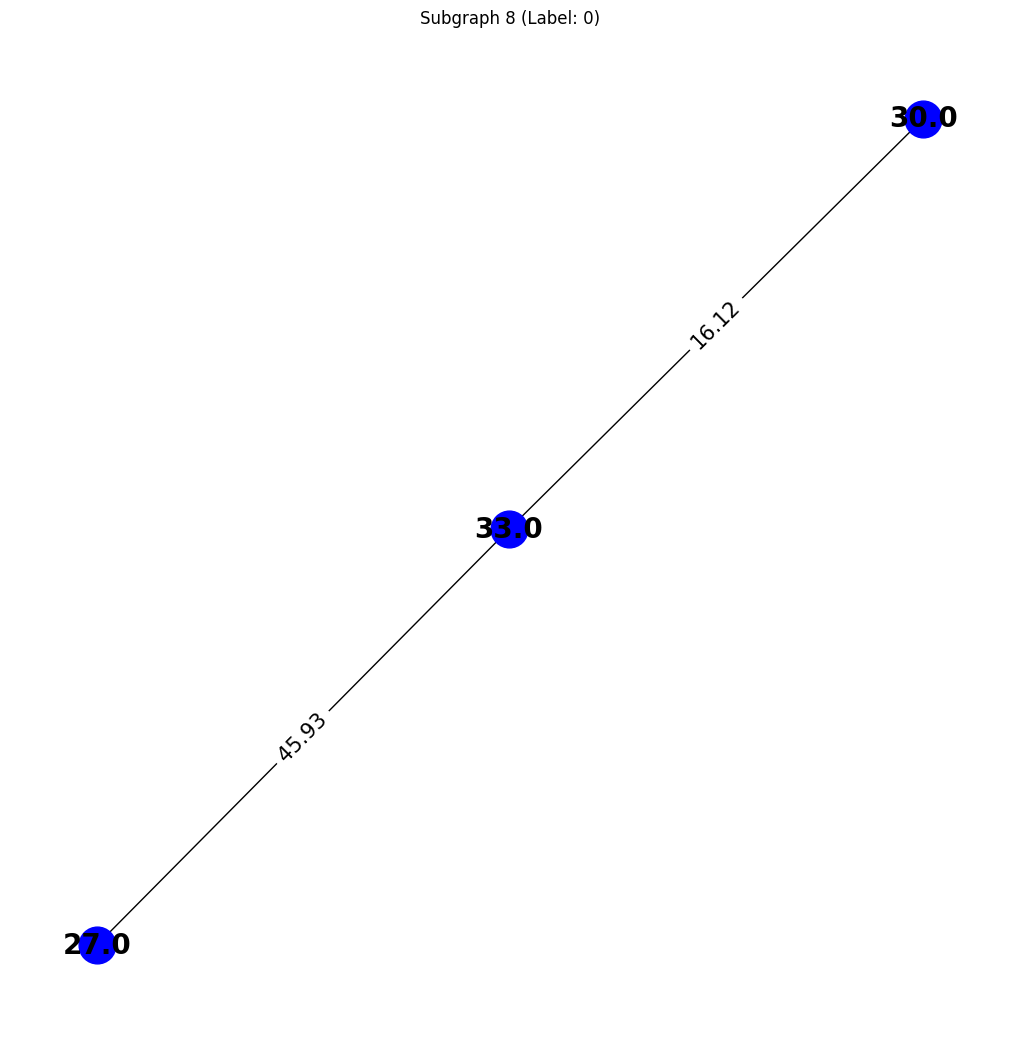

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_all_subgraphs_at_time(ts_subgraphs_dict, specific_ts):
    if specific_ts not in ts_subgraphs_dict:
        print(f"No subgraphs found for time {specific_ts}.")
        return
    
    subgraphs_at_ts = ts_subgraphs_dict[specific_ts]

    for i, subgraph in enumerate(subgraphs_at_ts):
        plt.figure(figsize=(10, 10))
        
        label = subgraph.graph['label']
        color_map = 'red' if label == 1 else 'blue'
        
        edge_labels = {}
        for u, v in subgraph.edges():
            edge_labels[(u, v)] = subgraph[u][v].get('dist', 0)
        
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True, node_color=color_map, font_weight='bold', node_size=700, font_size=20)
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=15)
        
        plt.title(f"Subgraph {i + 1} (Label: {label})")
        plt.show()
    
    
plot_all_subgraphs_at_time(ts_subgraphs_dict, 100)

In [9]:



positive_count, negative_count = count_labels_in_subgraphs(ts_subgraphs_dict)
print(f"Positive subgraphs: {positive_count}")
print(f"Negative subgraphs: {negative_count}")

Positive subgraphs: 839
Negative subgraphs: 16168


In [7]:



DATASET_TASK = DatasetTask.SUBGRAPH_CLASSIFICATION.value
DATASET_TYPE = DatasetType.SUBGRAPH_CLASSIFICATION_DISTANCE_LABELS.value
set_constants(DATASET_TYPE, DATASET_TASK)

output_name = get_dataset_file_path()

with open(output_name, 'wb') as f:
    pickle.dump(ts_subgraphs_dict, f)